In [46]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [47]:
import torch
import torch.nn as nn
import re
import itertools
import numpy as np
import random
import time
import math
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [48]:
vocabulary_size = 2500
unknown_token = "UNKNOWN_TOKEN"
sentence_start = "START"
sentence_end = "END"

In [49]:
def pad_sequences(sequences, max_length):
    padded = []
    for seq in sequences:
        if len(seq) < max_length:
            padded_seq = seq + [0] * (max_length - len(seq))  # Pad with 0s
        else:
            padded_seq = seq[:max_length]  # Trim to max_length
        padded.append(padded_seq)
    return padded


In [51]:
def preprocessing():
    data = open('/data/test2.txt', 'r', encoding="utf-8-sig")
    lines = data.read()
    data.close()
    all_sentences = [sent for sent in nltk.sent_tokenize(lines)]
    all_filtered = []

    for sent in all_sentences:
        filtered = re.sub('[A-Z]+[A-Z]+[A-Z]*', '', sent)
        filtered = re.sub('Mr\s*\.|Mrs\s*\.|Dr\s*\.', '', filtered)
        filtered = re.sub('\s+[A-Z]+[a-z]+', '', filtered)
        filtered = re.sub(" \d+", '', filtered)
        filtered = re.sub("[:,;“”]", ' ', filtered)
        filtered = filtered.lower()
        filtered = re.sub("\.", ' END', filtered)
        all_filtered.append("%s %s" % (sentence_start, filtered))

    all_tokens = []
    for sent in all_filtered:
        all_tokens.append(nltk.word_tokenize(sent))

    word_frequencies = nltk.FreqDist(itertools.chain(*all_tokens))
    vocabulary = word_frequencies.most_common(vocabulary_size - 1)
    index_to_word = [tup[0] for tup in vocabulary]
    index_to_word.append(unknown_token)
    word_to_index = {w: i for i, w in enumerate(index_to_word)}

    for i, sentence in enumerate(all_tokens):
        all_tokens[i] = [word if word in word_to_index else unknown_token for word in sentence]

    max_length = max(len(sent) for sent in all_tokens)

    # Pad sequences
    padded_tokens = pad_sequences([[word_to_index[word] for word in sent] for sent in all_tokens], max_length)

    X_train = np.asarray([seq[:-1] for seq in padded_tokens])
    y_train = np.asarray([seq[1:] for seq in padded_tokens])

    f = open('/data/X_train.txt', 'w')
    for sent in X_train:
        f.write(str(sent) + '\n')

    return X_train, y_train, index_to_word


In [52]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.l_in = nn.Linear(input_size, hidden_size)
        self.l_hidden = nn.Linear(hidden_size, hidden_size)
        self.l_out = nn.Linear(hidden_size, output_size)
        # self.dropout = nn.Dropout(0.2)

        self.relu = nn.ReLU()
        self.tan = nn.Tanh()

    def forward(self, input, hidden):
        inp = self.relu(self.l_in(input))
        hidden = self.tan(self.l_hidden(hidden + inp))
        output = self.l_out(hidden)
        # output = self.dropout(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size), requires_grad=True)


def sentence_to_tensor(sentence):
    tensor = torch.zeros(len(sentence), 1, vocabulary_size)
    for wi, word in enumerate(sentence):
        tensor[wi][0][word] = 1
    return tensor


def pick_random(l):
    random_index = random.randint(0, len(l) - 1)
    return l[random_index], random_index


def random_training_ex(X_train, y_train):
    random_X_train_example, random_index = pick_random(X_train)
    random_y_train_example = y_train[random_index]

    x_tensor = sentence_to_tensor(random_X_train_example)
    y_tensor = torch.LongTensor(random_y_train_example)

    return x_tensor, y_tensor


def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [53]:
def train(rnn, optimizer, y_tensor, x_tensor):
    y_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    loss = 0

    # complete bptt
    T = x_tensor.size()[0]
    for t in range(T):
        output, hidden = rnn(x_tensor[t], hidden)
        loss += criterion(output, y_tensor[t])

    # truncated bptt
    """T = x_tensor.size()[0]
    k = 15
    if T > k:
        for p in rnn.parameters():
            p.requires_grad = False

    for t in range(T):
        output, hidden = rnn(x_tensor[t], hidden)
        if T - t == k:
            for p in rnn.parameters():
                p.requires_grad = True
        if T - t < k:
            loss += criterion(output, y_tensor[t])"""

    loss.backward()
    optimizer.step()

    # updating weights explicitly
    # for p in rnn.parameters():
    #    p.data.add_(-learning_rate, p.grad.data)

    return loss.item() / x_tensor.size(0)


In [54]:
def evaluate(rnn, metric, temperature=0.8):
    length = random.randint(10, 25)
    result = []

    input = sentence_to_tensor(np.array([1]))  # Starting with the START token
    hidden = rnn.initHidden()

    for i in range(length):
        output, hidden = rnn(input[0], hidden)
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0].item()
        pred_word = metric[top_i]

        if pred_word == sentence_end:
            break
        elif pred_word != unknown_token:
            result.append(pred_word)

        input = sentence_to_tensor(np.array([top_i]))  # Update input with predicted word

    # Return the generated sentence
    return " ".join(result)

In [55]:
epochs = 10000
print_every = 500
plot_every = 50
hidden_size = 100
learning_rate = 0.005

criterion = nn.CrossEntropyLoss()

0m 43s (500 5%) 2.0988974938
1m 29s (1000 10%) 0.4855050796
2m 13s (1500 15%) 0.6227860084
2m 57s (2000 20%) 0.3866023039
3m 43s (2500 25%) 0.7169957772
4m 27s (3000 30%) 0.2480495649
5m 12s (3500 35%) 0.9599076296
5m 57s (4000 40%) 0.5500157185
6m 41s (4500 45%) 1.4045724135
7m 29s (5000 50%) 0.6792481251
8m 16s (5500 55%) 1.7031983596
9m 3s (6000 60%) 0.2863787871
9m 48s (6500 65%) 0.9428809728
10m 32s (7000 70%) 1.2361229138
11m 17s (7500 75%) 1.0550867716
12m 1s (8000 80%) 0.2564630019
12m 46s (8500 85%) 0.6499975156
13m 30s (9000 90%) 0.7453460693
14m 14s (9500 95%) 0.8940016918
14m 59s (10000 100%) 1.1400608161


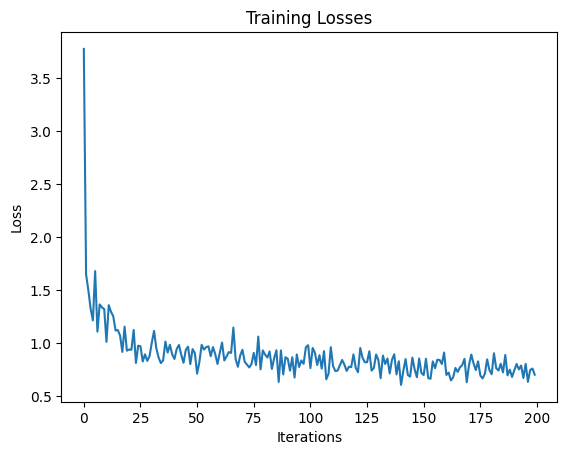

Generated Sentence 1: i had to very good boy you never 're to get us
Generated Sentence 2: i did n't even get home talking to you never said
Generated Sentence 3: oh i did to go to go of the closet and all
Generated Sentence 4: holden no he had her effect for a little time
Generated Sentence 5: do you ? all over as dough
Generated Sentence 6: i 'll doing she was reading to that and all
Generated Sentence 7: it was a big glass under the way and all
Generated Sentence 8: i got to throw you 'd just damn quite about movies
Generated Sentence 9: do n't know
Generated Sentence 10: old i 've feeling getting known girl i did n't like hardly if you 're a bunch of
Generated Sentence 11: i had finished on the room
Generated Sentence 12: i started simply the first pro ?
Generated Sentence 13: i said like on all of and
Generated Sentence 14: it was a funny stupid guy around the and and 'd could instance it hung it
Generated Sentence 15: what i sat near if everybody looked in the together in the not

In [57]:
X_train, y_train, index_to_word = preprocessing()
model = RNN(vocabulary_size, hidden_size, vocabulary_size)
start = time.time()
all_losses = []
current_loss = 0
optimizer = torch.optim.Adam(model.parameters())

for iter in range(1, epochs + 1):
  x_tensor, y_tensor = random_training_ex(X_train, y_train)
  loss = train(model, optimizer, y_tensor, x_tensor)
  current_loss += loss

  if iter % print_every == 0:
    print('%s (%d %d%%) %.10f' % (time_since(start), iter, iter / epochs * 100, loss))

  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

plt.figure()
plt.plot(all_losses)
plt.title('Training Losses')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

for i in range(30):
  generated_sentence = evaluate(model, index_to_word, temperature=0.8)
  print(f"Generated Sentence {i + 1}: {generated_sentence}")

0m 47s (500 5%) 0.6800582592
1m 32s (1000 10%) 1.3643181630
2m 18s (1500 15%) 0.2210608018
3m 2s (2000 20%) 0.3630949901
3m 48s (2500 25%) 0.9965762603
4m 33s (3000 30%) 0.8262151082
5m 19s (3500 35%) 0.4569919293
6m 6s (4000 40%) 1.0067222791
6m 52s (4500 45%) 0.4338288429
7m 37s (5000 50%) 1.2134356376
8m 21s (5500 55%) 1.3276191125
9m 6s (6000 60%) 0.8837114970
9m 51s (6500 65%) 0.2609307705
10m 36s (7000 70%) 0.4828401712
11m 21s (7500 75%) 1.9574890137
12m 12s (8000 80%) 1.0652753390
12m 59s (8500 85%) 1.3076480963
13m 50s (9000 90%) 0.2882389411
14m 45s (9500 95%) 0.7646987622
15m 47s (10000 100%) 0.9574345320
i could going to say
i knew it
i even even spent some girl i really
if you 're anything about one of the just did in the whole room men
every 's of once to tell i turned through the one of very stupid part of the
you wo n't be your whole hell to me it
i just all as hell
i just just do it a good right times
that was very whole matter of the mood
i mean `` you to be a little 

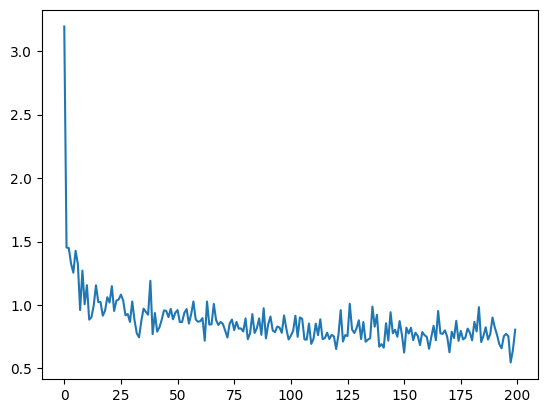

In [32]:
main()